This file was done by Raissa Rae Makonga - r0917910

# [Kaggle Titanic Dataset Link](https://www.kaggle.com/competitions/titanic/overview)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


Reading the data from the kaggle competition

In [4]:
train = pd.read_csv('data/train/train.csv')
test = pd.read_csv('data/test/test.csv')

### Cleaning the data

Cleaning the data as requsted in the Github.

In [5]:
#rename 
train.columns = train.columns.str.lower().str.replace(' ', '_')
test.columns = test.columns.str.lower().str.replace(' ', '_')

Checking train data to see if theres an values and cleaning it up.

In [6]:
#checking for mising values in the train
train.isnull().sum()


passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

In [7]:
#dropping column - not needed.
train.drop('cabin', axis=1, inplace=True)

In [8]:
#a lot of ages missing so finding the median so it is not blank
train['age'].fillna(train['age'].median(), inplace=True)

Checking test data to see if theres an values and cleaning it up.

In [9]:
test.isnull().sum()

passengerid      0
pclass           0
name             0
sex              0
age             86
sibsp            0
parch            0
ticket           0
fare             1
cabin          327
embarked         0
dtype: int64

The next cell is in comments because it was ran twice and gave an error because the column was already dropped from the first time it ran.

In [10]:
#test.drop('cabin', axis=1, inplace=True)

In [11]:
#median for the ages as well
test['age'].fillna(test['age'].median(), inplace=True)

Creating new dataframes for numerical and categorical, the separation is helpful for performing different analysis

In [12]:
train_num = train[['age','sibsp','parch','fare']]
train_cat = train[['survived','pclass','sex','ticket','embarked']]

Showing the average values for the values for each of the survival group.

In [13]:
pd.pivot_table(train, index = 'survived', values = ['age','sibsp','parch','fare'])

,age,fare,parch,sibsp
survived,,,,
0,30.028233,22.117887,0.329690,0.553734
1,28.291433,48.395408,0.464912,0.473684


Checking to see the number of outliers in Fare and Age and decided to cap them, i thought they were still valid.

In [14]:
# Calculate IQR for 'Fare' and 'Age'
Q1_fare = train['fare'].quantile(0.25)
Q3_fare = train['fare'].quantile(0.75)
IQR_fare = Q3_fare - Q1_fare

Q1_age = train['age'].quantile(0.25)
Q3_age = train['age'].quantile(0.75)
IQR_age = Q3_age - Q1_age

# Define outlier thresholds for Fare and Age
fare_lower_bound = Q1_fare - 1.5 * IQR_fare
fare_upper_bound = Q3_fare + 1.5 * IQR_fare

age_lower_bound = Q1_age - 1.5 * IQR_age
age_upper_bound = Q3_age + 1.5 * IQR_age

# Check for outliers
outliers_fare = train[(train['fare'] < fare_lower_bound) | (train['fare'] > fare_upper_bound)]
outliers_age = train[(train['age'] < age_lower_bound) | (train['age'] > age_upper_bound)]

print("Number of Fare outliers:", len(outliers_fare))
print("Number of Age outliers:", len(outliers_age))

Number of Fare outliers: 116
Number of Age outliers: 66


In [15]:
# Capping outliers for 'Fare' and 'Age' at the 1st and 99th percentiles
fare_cap_low = train['fare'].quantile(0.01)
fare_cap_high = train['fare'].quantile(0.99)
train['fare'] = train['fare'].clip(lower=fare_cap_low, upper=fare_cap_high)

age_cap_low = train['age'].quantile(0.01)
age_cap_high = train['age'].quantile(0.99)
train['age'] = train['age'].clip(lower=age_cap_low, upper=age_cap_high)


In [16]:
# Convert Pclass into an ordered categorical feature
train['pclass'] = pd.Categorical(train['pclass'], categories=[1, 2, 3], ordered=True)

# Convert Sex and Embarked into categorical types (unordered)
train['sex'] = train['sex'].astype('category')
train['embarked'] = train['embarked'].astype('category')

# Check the data types to confirm
print(train.dtypes)

passengerid       int64
survived          int64
pclass         category
name             object
sex            category
age             float64
sibsp             int64
parch             int64
ticket           object
fare            float64
embarked       category
dtype: object


pivot table to average count the number of tickets for each chosen column

In [17]:
print(pd.pivot_table(train, index = 'survived', columns = 'pclass', values = 'ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train, index = 'survived', columns = 'sex', values = 'ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train, index = 'survived', columns = 'embarked', values = 'ticket' ,aggfunc ='count'))

pclass      1   2    3
survived              
0          80  97  372
1         136  87  119

sex       female  male
survived              
0             81   468
1            233   109

embarked   C   Q    S
survived             
0         75  47  427
1         93  30  217


dropping the survived column

In [18]:
# final_train_data = train.drop('survived', axis =1)

# final_train_data

In [19]:
train

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


## Building the model

Before uploading the final test and train data to the bucket. I thought it would best to clean it locally first. I used the next cell blocks to do so. <span style="color:red">The rename is the same, the only thing that I did different is that I one-hot coded because to train in AWS xgboost only could train numericals.</span>

In [20]:
train['embarked'].fillna(train['embarked'].mode()[0], inplace=True)

In [21]:
train

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [22]:
test.isnull().sum()

passengerid      0
pclass           0
name             0
sex              0
age              0
sibsp            0
parch            0
ticket           0
fare             1
cabin          327
embarked         0
dtype: int64

In [23]:
test.drop('cabin', axis=1, inplace=True)

#median for the ages as well
test['age'].fillna(test['age'].median(), inplace=True)
test['fare'].fillna(test['fare'].median(), inplace=True)

test.isnull().sum()

passengerid    0
pclass         0
name           0
sex            0
age            0
sibsp          0
parch          0
ticket         0
fare           0
embarked       0
dtype: int64

In [24]:
# Encode 'sex' column
train['sex'] = train['sex'].map({'male': 0, 'female': 1})
test['sex'] = test['sex'].map({'male': 0, 'female': 1})

# Encode 'embarked' column
train['embarked'] = train['embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test['embarked'] = test['embarked'].map({'S': 0, 'C': 1, 'Q': 2})

I dropped irrelevant columns

In [25]:
train.drop(['name', 'ticket', 'passengerid'], axis=1, inplace=True)
test.drop(['name', 'ticket'], axis=1, inplace=True)  # Keep `passengerid` in test for final submission


Double checking to make sure the two datasets matches

In [26]:
test

,passengerid,pclass,sex,age,sibsp,parch,fare,embarked
0,892,3,0,34.5,0,0,7.8292,2
1,893,3,1,47.0,1,0,7.0000,0
2,894,2,0,62.0,0,0,9.6875,2
3,895,3,0,27.0,0,0,8.6625,0
4,896,3,1,22.0,1,1,12.2875,0
...,...,...,...,...,...,...,...,...
413,1305,3,0,27.0,0,0,8.0500,0
414,1306,1,1,39.0,0,0,108.9000,1
415,1307,3,0,38.5,0,0,7.2500,0
416,1308,3,0,27.0,0,0,8.0500,0


In [27]:
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,0
887,1,1,1,19.0,0,0,30.0000,0
888,0,3,1,28.0,1,2,23.4500,0
889,1,1,0,26.0,0,0,30.0000,1


In [ ]:
# Verify the target column
print(train['survived'].unique())  


[0 1]


In [29]:
train.to_csv('final_train.csv', index=False, header=False)
test.to_csv('final_test.csv', index=False, header=False)

Here is the link to the training part of the model.

[Link to the AWS notebook](./notebook_AWS%20(1).ipynb)


## Model building using PyCaret

In [ ]:
#prepping the data for modelling 

titanic_clf_setup = setup(data=train, target='survived', session_id=123)

,Description,Value
0,Session id,123
1,Target,survived
2,Target type,Binary
3,Original data shape,"(891, 11)"
4,Transformed data shape,"(891, 15)"
5,Transformed train set shape,"(623, 15)"
6,Transformed test set shape,"(268, 15)"
7,Numeric features,5
8,Categorical features,5
9,Rows with missing values,0.2%


Decided to use API because this project is quite simple and does not need scaling or deployment.

In [ ]:
# Compare different classification models using API
best_model = compare_models()
best_model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8072,0.8652,0.6739,0.7915,0.7244,0.5788,0.5857,0.1960
ridge,Ridge Classifier,0.7752,0.8634,0.5107,0.8414,0.6318,0.4855,0.5183,0.2010
et,Extra Trees Classifier,0.7187,0.7560,0.4563,0.7192,0.5428,0.3604,0.3861,0.1570
nb,Naive Bayes,0.6292,0.8007,0.0464,0.4167,0.0832,0.0465,0.0880,0.0990
knn,K Neighbors Classifier,0.6291,0.5961,0.3649,0.5205,0.4242,0.1670,0.1732,0.1120
lda,Linear Discriminant Analysis,0.6260,0.5377,0.0348,0.0800,0.0485,0.0335,0.0389,0.0870
dt,Decision Tree Classifier,0.6164,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0790
rf,Random Forest Classifier,0.6164,0.8136,0.0000,0.0000,0.0000,0.0000,0.0000,0.2830
qda,Quadratic Discriminant Analysis,0.6164,0.4904,0.0000,0.0000,0.0000,0.0000,0.0000,0.1370
ada,Ada Boost Classifier,0.6164,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1470


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Tuning the best model to improve performance

In [ ]:
# Automatically tune the best model's hyperparameters
tuned_model = tune_model(best_model, verbose=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7937,0.8536,0.7083,0.7391,0.7234,0.5590,0.5593
1,0.7937,0.8194,0.6250,0.7895,0.6977,0.5442,0.5528
2,0.9206,0.9658,0.8333,0.9524,0.8889,0.8276,0.8321
3,0.8548,0.8930,0.7826,0.8182,0.8000,0.6862,0.6866
4,0.7258,0.8125,0.4583,0.7333,0.5641,0.3793,0.4016
5,0.7581,0.8333,0.7083,0.6800,0.6939,0.4940,0.4943
6,0.8065,0.7982,0.6250,0.8333,0.7143,0.5724,0.5860
7,0.8226,0.8717,0.7917,0.7600,0.7755,0.6289,0.6293
8,0.7419,0.8377,0.5833,0.7000,0.6364,0.4389,0.4433


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
# Evaluate the tuned model
evaluate_model(tuned_model)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# Finalize the model
final_model = finalize_model(tuned_model)

# Predictions on the test set
predictions = predict_model(final_model, data=test)

In [ ]:
predictions_to_save = predictions[['passengerid', 'prediction_label']] #selecting only the important columns to save
predictions_to_save = predictions_to_save.rename(columns={'prediction_label': 'survived'})


In [ ]:
predictions_to_save.to_csv('results/predictionsPYCARET.csv', index=False)  # Save the output CSV

These are the results on Kaggle.

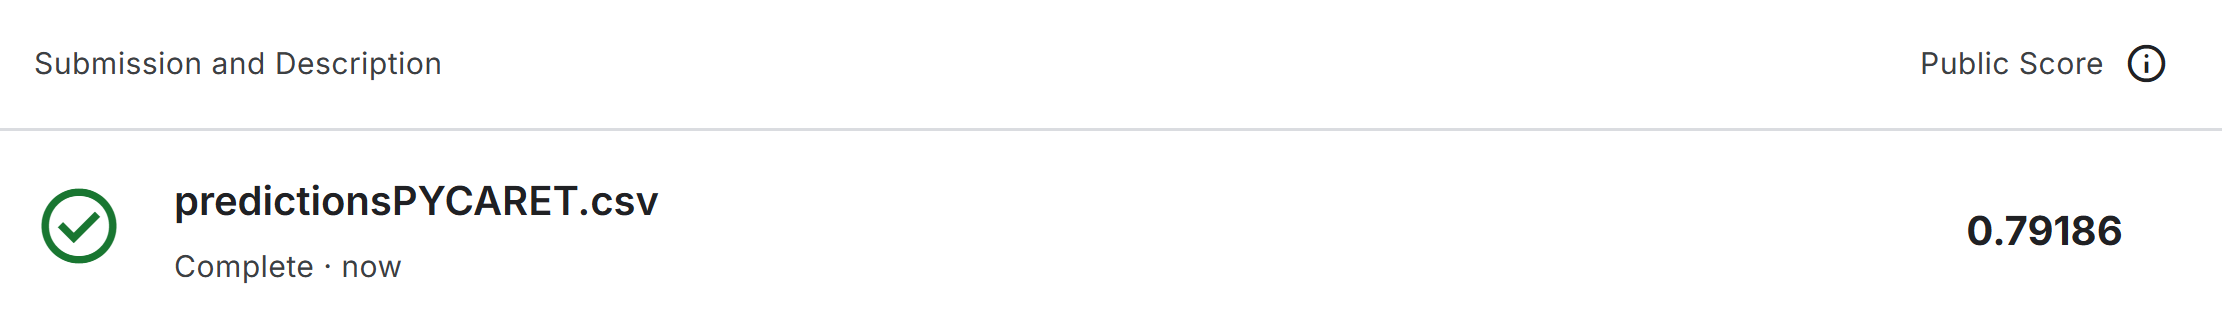

## Manually creating a model

Comparing multiple models (Random Forest, Logistic Regression and K-Nearest Neighbors (KNN)) this will allow me to choose the best performing one.

Logistic Regression Accuracy: 0.81

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



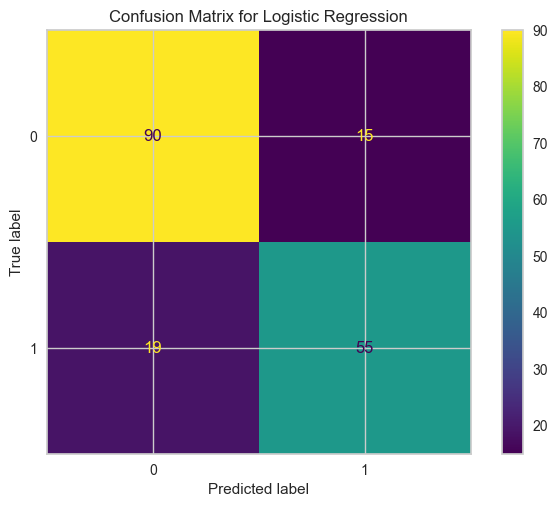

Random Forest Accuracy: 0.83

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       105
           1       0.80      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



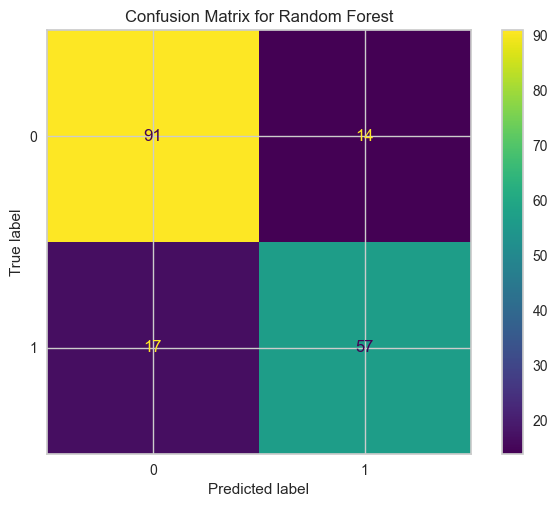

KNN Accuracy: 0.72

KNN Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.85      0.78       105
           1       0.71      0.54      0.62        74

    accuracy                           0.72       179
   macro avg       0.72      0.69      0.70       179
weighted avg       0.72      0.72      0.71       179



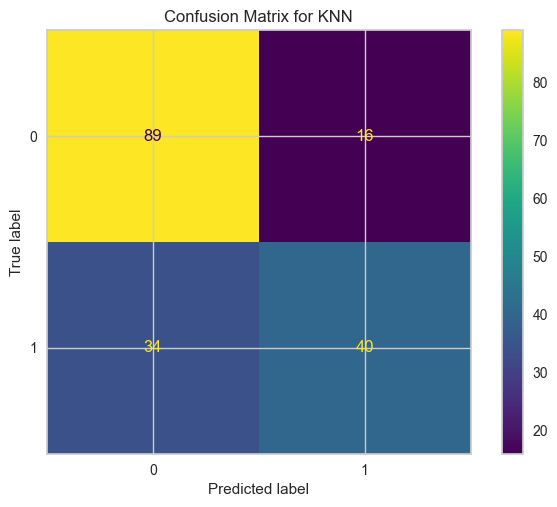

In [ ]:
#splitting the data into 80% training and 20% validation 
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#the 3 different models are initialized
log_reg = LogisticRegression(max_iter=1000) #enough iterations
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42) #mentions the number of trees in the Random Forest
knn_clf = KNeighborsClassifier(n_neighbors=5) #sets it to 5 neighbours

#train and evaluate
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_clf,
    "KNN": knn_clf
}

results = {}

#training each model to the data    
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_split, y_train_split)

        # Predict on validation set
    val_predictions = model.predict(X_val)
    
    # Evaluate the model
    accuracy = accuracy_score(y_val, val_predictions)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_val, val_predictions))
    
    # Save results for comparison
    results[model_name] = accuracy
    
    # Confusion matrix visualization
    conf_matrix = confusion_matrix(y_val, val_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

In [ ]:
# Compare model scores
print("\nModel Comparison:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.2f}")

# Select the best model for final predictions
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")

# Predict survival on the test data using the best model
test_predictions = best_model.predict(X_test)

# Create a submission file
submission = pd.DataFrame({
    'PassengerId': test['passengerid'],  # Ensure 'passengerid' matches the test data
    'Survived': test_predictions         # Predictions from the model
})

# Save the submission file
submission.to_csv(f'results/submission_{best_model_name.replace(" ", "_").lower()}.csv', index=False)
print(f"\nSubmission file saved as 'results/submission_{best_model_name.replace(' ', '_').lower()}.csv'.")



Model Comparison:
Logistic Regression: 0.81
Random Forest: 0.83
KNN: 0.72

Best Model: Random Forest

Submission file saved as 'results/submission_random_forest.csv'.


Despite Random Forest being the best model, the Logistic Regression scored higher on Kaggle when uploaded.

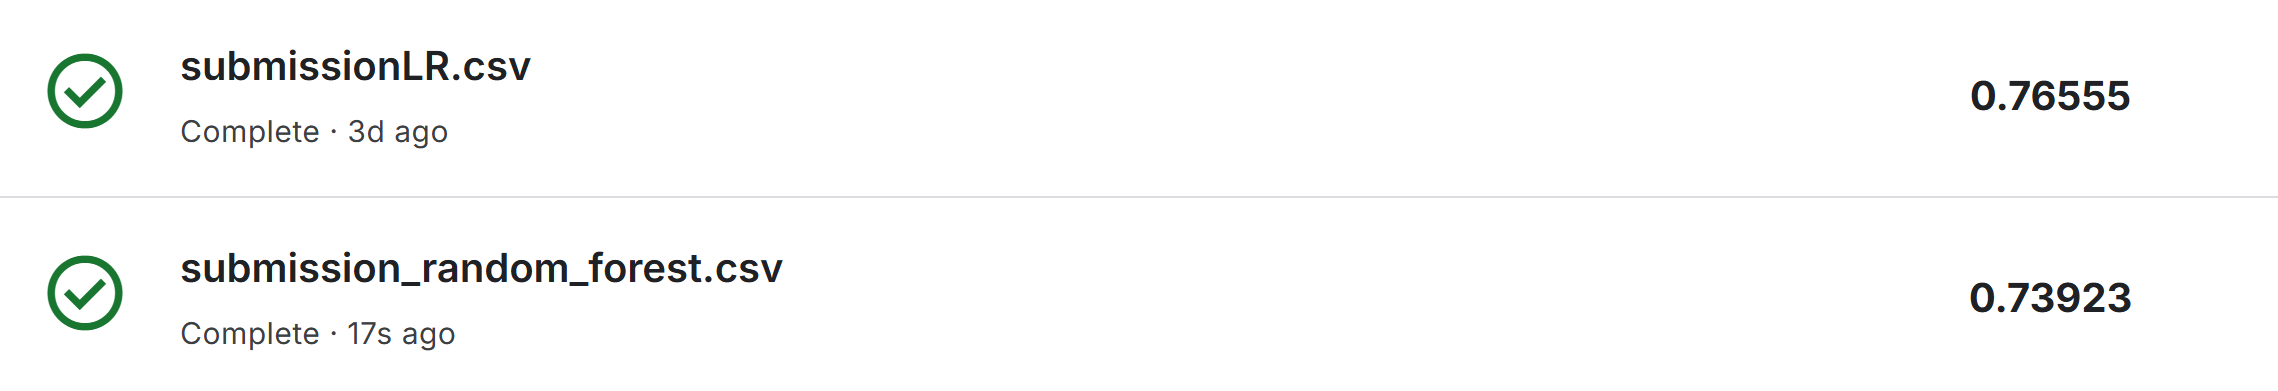